In [3]:
import netCDF4
import xarray as xr
import xesmf as xe
from itertools import cycle
import os
import dask
import numpy as np
import pandas as pd
import dask.array as da
import dask.bag as db
from pykdtree.kdtree import KDTree
from dask.diagnostics import ProgressBar
import subprocess
import matplotlib.pyplot as plt


# Import scripts
from regional_model_scripts import input_datasets, interp_segment,prepare_segments, time_rotate,regrid_runoff,sel_hgrid_indices
from boundary_tides import write_tpxo

om2path = "/g/data/ik11/inputs/access-om2/input_08022019/mom_01deg/" ## Access om2_01 input for topography and hgrid
initpath = "/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output1077" ## Access om2_01 output for BCs and IC
toolpath = "/home/157/ahg157/repos/mom5/src/tools/" ## Compiled tools needed for construction of mask tables
    
xr.set_options(keep_attrs=True) ## This ensures that performing simple operations with xarray (eg converting temperature to Celsius) preserves attributes

from dask.distributed import Client
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37659 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37659/status,
Dashboard: /proxy/37659/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39089,Workers: 7
Dashboard: /proxy/37659/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:40743,Total threads: 4
Dashboard: /proxy/43893/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:43967,


In [2]:
import os 
os.chdir("cosima_regional/mom6-regional-scripts")
print(os.getcwd())

/home/149/ab8992/cosima_regional/mom6-regional-scripts


# What this notebook does:

Given a choice of lat / lon coordinates, a hgrid is built from an existing access om2_01 global run. Then, all of the other required input files are interpolated onto this hgrid, and Angus Gibson's 'Brushcutter' creates files for boundary files. It also sets up the mask tables and regrids the runoff, sorting out everything you need to run the experiment.

An input directory is copied into the 'rundir' you choose, and a couple of files are automatically modified based on your experiment. As longs as you don't change your default layout, you

# What's still to do:

* Test whether this setup works for a pan-antarctic style domain. In that case you'd need to set REENTRANT_X = True in MOM_input. Otherwise there might be some other things that need changing to ensure that the input files wrap around properly
* Automate the procedure for changing the resolution. I think this can be done by constructing a new hgrid of whatever resolution, then interpolating everything else onto it as before. Would require reading in a high resolution topography, but otherwise could use the access om2-01 forcing at boundary and initially
* Handle the case where you want to look at a domain that straddles the 'seam' in longitude coordinate at -180.

# Troubleshooting:
* You can get some really weird errors if there are little bays trapped on your boundaries. Try to either avoid this, or fill them in manually if they appear. This is what I was getting: 

"FATAL from PE    56: MOM_regridding: adjust_interface_motion() - implied h<0 is larger than roundoff!"

* If you alter the remapping code, be sure to check that your netcdf files have sensible attributes. You can check yours against a working model by ensuring your attributes match with /scratch/v45/ab8992/mom6/regional_configs/ttide-new/

## Choose your Domain, and set path to your input and run directories

Text(0.5, 1.0, 'test_30th domain')

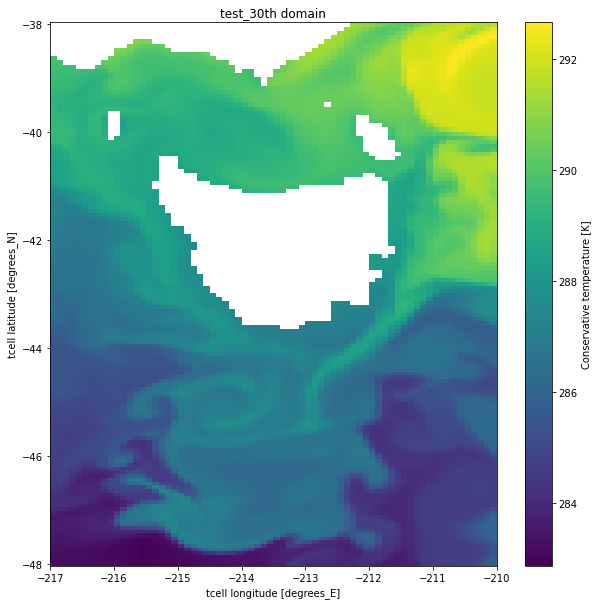

In [4]:

## Choose your coordinates and the name of your experiment
yextent = [-48,-38]
xextent = [-217 , -210]
expt_name = "test_30th"

## Place where all your input files go
path = f"/scratch/v45/ab8992/mom6/regional_configs/{expt_name}/"

## Directory where you'll run the experiment from
rundir = f"/home/149/ab8992/mom6_rundirs/{expt_name}"

for i in [path,rundir]:
    try:
        os.mkdir(i)
    except:
        pass

if "temp" not in os.listdir(path):
    os.mkdir(path + "temp")
if "weights" not in os.listdir(path):
    os.mkdir(path + "weights")
if "forcing" not in os.listdir(path):
    os.mkdir(path + "forcing")


full_domain = xr.open_dataset(f"{initpath}/ocean/ocean_daily.nc")

# domain.tau_x.sel(yu_ocean=slice(-49, -5), xu_ocean=slice(-217, -183)).isel(time = 0).plot()
domain = full_domain.surface_temp.sel(yt_ocean=slice(yextent[0], yextent[1]), xt_ocean=slice(xextent[0],xextent[1])).isel(time = 0)
fig,ax = plt.subplots(1,figsize = (10,10))

domain.plot(ax = ax)
ax.set_title(f"{expt_name} domain")

# Step by step procedure to set up experiment

## 1. Find the indices of the hgrid that we need based on the lat/lon chosen above

In [5]:
hgrid = xr.open_dataset(om2path + "ocean_hgrid.nc")

x_indices_hgrid = sel_hgrid_indices(hgrid.x.isel(nyp = 1000,nxp = slice(0,None,2)),xextent)  ## As long as it's away from the north pole things are ok since lon doesn't vary with lat
y_indices_hgrid = sel_hgrid_indices(hgrid.y.isel(nxp = 0,nyp = slice(0,None,2)),yextent) 

encoding = {'x': {'_FillValue': None},
            'y': {'_FillValue': None},
            "dx": {"_FillValue": None},
            'dy': {'_FillValue': None},
            'angle_dx': {'_FillValue': None},
            'area': {'_FillValue': None}
            }  

hgrid_new = hgrid.isel(
    nyp = slice(y_indices_hgrid[0] , y_indices_hgrid[1] ),
    nxp = slice(x_indices_hgrid[0] , x_indices_hgrid[1] ),
    ny = slice(y_indices_hgrid[0] , y_indices_hgrid[1] - 1 ),
    nx = slice(x_indices_hgrid[0] , x_indices_hgrid[1] - 1 ))

hgrid_new.to_netcdf(path + "hgrid.nc",mode = "w",encoding = encoding)

## 2. Cut out the initial condition velocities and interpolate onto the cgrid

Here we can use the normal xarray select tool to get the initial velocities. This is set by default to be at time=30, as this is how Angus set things up. 

The horizontal coordinates are a bit of a mess. Initially, the mom5 data uses xu_ocean,xt_ocean etc. In MOM6, yh,xq etc are used. Here, they're renamed to "lat/lon" for the regridder. Afterwards, the velocities are named in the "xh,yq" convention, but the tracers aren't. This is to be consistent with Angus' example EAC configuration. I suspect there would be no issue renaming the coordinates consistently if the relevent MOM files were altered to match. 

Note also that the "encoding" parameters are needed to overwrite xarray's default values. xr will put in its own NaNs as the _FillVallue which aren't compatible with MOM6

In [9]:
## pull out the initial velocity on MOM5's Bgrid
u_init_bgrid = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_u.nc").u.rename({"xu_ocean": "lon", "yu_ocean": "lat"}).sel(
    lon = slice(xextent[0],xextent[1]),lat = slice(yextent[0],yextent[1])).isel(time = 30)
v_init_bgrid = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_v.nc").v.rename({"xu_ocean": "lon", "yu_ocean": "lat"}).sel(
    lon = slice(xextent[0],xextent[1]),lat = slice(yextent[0],yextent[1])).isel(time = 30)

## Pull out the surface height, temp and salinity initial conds
temperature = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_temp.nc").temp.isel(time = 30).sel(
    yt_ocean = slice(yextent[0],yextent[1]),xt_ocean = slice(xextent[0],xextent[1]))  - 273.15## Convert to Celcius for MOM6!
salt = xr.open_dataset(f"{initpath}/ocean/ocean_daily_3d_salt.nc").salt.isel(time = 30).sel(
    yt_ocean = slice(yextent[0],yextent[1]),xt_ocean = slice(xextent[0],xextent[1]))

## Merge tracer ICs together
init_cond = xr.merge([temperature,salt]).drop_vars("time").rename({"xt_ocean": "lon", "yt_ocean": "lat"})

init_eta = xr.open_dataset(f"{initpath}/ocean/ocean_daily.nc").isel(time = 30).sel(
    yt_ocean = slice(yextent[0],yextent[1]),xt_ocean = slice(xextent[0],xextent[1])).rename({"xt_ocean": "lon", "yt_ocean": "lat"})


## Construct the xq,yh and xh yq grids
ugrid = hgrid_new[["x","y"]].isel(nxp=slice(None, None, 2), nyp=slice(1, None, 2)).rename({"x": "lon", "y": "lat"})
vgrid = hgrid_new[["x","y"]].isel(nxp=slice(1, None, 2), nyp=slice(None, None, 2)).rename({"x": "lon", "y": "lat"})

ugrid.set_coords(["lat","lon"])
vgrid.set_coords(["lat","lon"])


## Construct the cell centre grid for tracers (xh,yh). 
tgrid = xr.Dataset(
    {"lon":(["lon"],hgrid_new.x.isel(nxp=slice(1, None, 2), nyp=1).values),
     "lat":(["lat"],hgrid_new.y.isel(nxp=1, nyp=slice(1, None, 2)).values)
            }
)

# ugrid = xr.DataSet(
    
# )


regridder_u = xe.Regridder(
    u_init_bgrid, ugrid, "bilinear",
)
regridder_v = xe.Regridder(
    v_init_bgrid, vgrid, "bilinear",
)

regridder_t = xe.Regridder(
    init_cond, tgrid, "bilinear",
)

u_on_c = regridder_u(u_init_bgrid)

print(u_on_c.coords)

# u_on_c = u_on_c.rename({"nyp": "ny"})
u_on_c = u_on_c.rename({"lon": "xq", "lat": "yh", "nyp": "ny"})

print(u_on_c.coords)

u_on_c.name = "u"
## Give attributes back
u_on_c.attrs = u_init_bgrid.attrs 
u_on_c.xq.attrs = u_init_bgrid.lon.attrs
u_on_c.yh.attrs = u_init_bgrid.lat.attrs
u_on_c.st_ocean.attrs = u_init_bgrid.st_ocean.attrs

v_on_c = regridder_v(v_init_bgrid)
v_on_c = v_on_c.rename({"lon": "xh", "lat": "yq", "nxp": "nx"})
# v_on_c = v_on_c.rename({"nxp": "nx"})

v_on_c.name = "v"
## Give attributes back
v_on_c.attrs = v_init_bgrid.attrs 
v_on_c.xh.attrs = v_init_bgrid.lon.attrs
v_on_c.yq.attrs = v_init_bgrid.lat.attrs
v_on_c.st_ocean.attrs = v_init_bgrid.st_ocean.attrs

vel_init_cgrid = xr.merge((u_on_c, v_on_c),)
vel_init_cgrid.st_ocean.attrs["axis"] = "Z"

vel_init_cgrid.fillna(0).drop_vars("time").to_netcdf(
    path + "forcing/init_vel_cgrid.nc",
    mode = "w",
    encoding={
        "u": {"_FillValue": netCDF4.default_fillvals["f4"]},
        "v": {"_FillValue": netCDF4.default_fillvals["f4"]}        
    },
)


## regrid tracers
init_cond_rg = regridder_t(init_cond)
init_cond_rg = init_cond_rg.rename({"lon": "xt_ocean", "lat": "yt_ocean"})
## Give attributes back
init_cond_rg.attrs = init_cond.attrs 
init_cond_rg.xt_ocean.attrs = init_cond.lon.attrs
init_cond_rg.yt_ocean.attrs = init_cond.lat.attrs
init_cond_rg.st_ocean.attrs = init_cond.st_ocean.attrs

init_cond_rg.to_netcdf(
    path + "forcing/init_cond.nc",
    mode = "w",
    encoding = {'xt_ocean': {'_FillValue': None},
                'yt_ocean': {'_FillValue': None},
                "st_ocean": {"_FillValue": None},
                'temp': {'_FillValue': -1e20,'missing_value': -1e20},
                'salt': {'_FillValue': -1e20,'missing_value': -1e20}
                },
)


## regrid eta
init_eta_rg = regridder_t(init_eta.eta_t)
init_eta_rg = init_eta_rg.rename({"lon": "xt_ocean", "lat": "yt_ocean"})

## Give attributes back
init_eta_rg.attrs = init_eta.attrs 
init_eta_rg.xt_ocean.attrs = init_eta.lon.attrs
init_eta_rg.yt_ocean.attrs = init_eta.lat.attrs

init_eta_rg.name = "eta_t"

init_eta_rg.drop_vars("time").to_netcdf(
    path + "forcing/init_eta.nc",
    mode = "w",
    encoding = {'xt_ocean': {'_FillValue': None},
                'yt_ocean': {'_FillValue': None},
                'eta_t':{'_FillValue':None}
                },
)


Coordinates:
    *empty*
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      object 2170-05-01 12:00:00
    lon       (nyp, nxp) float64 -217.0 -216.9 -216.8 ... -210.2 -210.1 -210.0
    lat       (nyp, nxp) float64 -47.93 -47.93 -47.93 ... -38.09 -38.09 -38.09
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
    time      object 2170-05-01 12:00:00
    xq        (ny, nxp) float64 -217.0 -216.9 -216.8 ... -210.2 -210.1 -210.0
    yh        (ny, nxp) float64 -47.93 -47.93 -47.93 ... -38.09 -38.09 -38.09


<xarray.Dataset>
Dimensions:  (nyp: 136, nxp: 71)
Coordinates:
    lon      (nyp, nxp) float64 -217.0 -216.9 -216.8 ... -210.2 -210.1 -210.0
    lat      (nyp, nxp) float64 -47.93 -47.93 -47.93 ... -38.09 -38.09 -38.09
Dimensions without coordinates: nyp, nxp
Data variables:
    *empty*

## 3 Get the topography, and cut out using the indices from hgrid

For now, this step assumes that we're just cutting the hgrid and topo from the same mom5 experiment. This means that the indices for cutting out the hgrid can be used to cut out the topo and runoff. If resolution changes, hgrid and topo will generated in some other way. Could also interpolate a topography file the same way as initial conditions above

In [9]:
topog = xr.open_dataset("/g/data/ik11/inputs/access-om2/input_08022019/mom_01deg/topog.nc").rename({"xx":"nx","yy":"ny"})
topog = topog.expand_dims({'ntiles':1})

x_indices_centre = x_indices_hgrid //2    ## To go from the hgrid's indices (which refer to cell edges) to cell centres, we just need to //2. 
y_indices_centre = y_indices_hgrid //2    ## For cell corners, we'd need to go hgrid //2 for start of slice, //2 + 1 for end of slice

encoding = {"depth":{'_FillValue': None}} 


topog.isel(nx = slice(x_indices_centre[0],x_indices_centre[1]) , ny = slice(y_indices_centre[0],y_indices_centre[1])).to_netcdf(path + "topog.nc",mode = "w",encoding = encoding)



## 4. Use the c executables from mom5 tools to construct the mosaic and mask tables

In [6]:

args = "--num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc".split(" ")

print("MAKE SOLO MOSAIC",subprocess.run([toolpath + "make_solo_mosaic/make_solo_mosaic"] + args,cwd = path),sep = "\n")

args = "--input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog topog.nc".split(" ")

print("QUICK MOSAIC" , subprocess.run([toolpath + "make_quick_mosaic/make_quick_mosaic"] + args,cwd = path),sep = "\n")


## I've set the layout to default to 10x10 cpus
args = "--grid_file ocean_mosaic.nc --ocean_topog topog.nc --layout 10,10 --halo 4".split(" ")

print("CHECK MASK" , subprocess.run([toolpath + "check_mask/check_mask"] + args,cwd = path))

NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
MAKE SOLO MOSAIC
CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_solo_mosaic/make_solo_mosaic', '--num_tiles', '1', '--dir', '.', '--mosaic_name', 'ocean_mosaic', '--tile_file', 'hgrid.nc'], returncode=0)
cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file topog.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
QUICK MOSAIC
CompletedProcess(args=['/home/157/ahg157/repos/mom5/src/tools/make_quick_mosaic/make_quick_mosaic', '--input_mosaic', 'ocean_mosaic.nc', '--mosaic_name', 'grid_spec', '--ocean_topog', 'topog.nc'], returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mo

cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


# 5. Prepare boundary segments

Use modified code from Angus' scripts. This cuts out the relevant boundary fields for the experiment and saves them to memory on the node

In [7]:
prepare_segments(xextent,yextent)

# 6. Brushcut

Use Angus' brushcut script to generate the boundary forcing files

In [3]:
surface_tracer_vars = ["temp", "salt"]
line_tracer_vars = ["eta_t"]
surface_velocity_vars = ["u", "v"]
surface_vars = surface_tracer_vars + surface_velocity_vars



for seg in enumerate([{"nyp": [0]}, {"nyp": [-1]}, {"nxp": [0]}, {"nxp": [-1]}]):
    interp_segment(seg,path)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable eta_t as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('yu_ocean', 'xu_ocean') from data variable u as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('yt_ocean', 'xt_ocean') from data variable eta_t as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('yu_ocean', 'xu_ocean') from data variable u as the horizontal dimensions for the regridding.
  warnings.wa

# 7. Cut Out and Regrid Runoff

Pull out runoff from JRA input, then run Angus' regrid runoff script

In [3]:
## Cut runoff from JRA input

runoff_path = "/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.runoff_all.1990_1991.nc"

regrid_runoff(path + "ocean_mask.nc",
    path + "hgrid.nc",
    runoff_path,
    path + "runoff_regrid.nc",
    xextent,
    yextent)



# 8. Set up files in run directory

Copy the default run directory files (MOM_input, config.yaml etc) to the new run directory. This script makes some modifications to match the settings in your experiment, namely the mask table, number of cpus required, experiment name and number of x and y grid points. Currently, if you change the layout from 10,10 you'll need to manually make your changes. Otherwise, your experiment should be ready to run after running all the cells in the notebook

In [10]:
subprocess.run(f"cp default_rundir/* {rundir}",shell = True)
subprocess.run(f"ln -s {path} {rundir}/inputdir",shell=True)

## Get mask table information
ncpus = 100
mask_table = None
for i in os.listdir(f"{path}"):
    if "mask_table" in i:
        mask_table = i
        a = mask_table.split(".")[1]
        b = mask_table.split(".")[2].split("x")
        ncpus = int(b[0]) * int(b[1]) - int(a)


## Modify MOM_input
inputfile = open(f"{rundir}/MOM_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        if mask_table != None:
            lines[i] = f'MASKTABLE = "{mask_table}"\n'
        else:
            lines[i] = "# MASKTABLE = no mask table"
    if "NIGLOBAL" in lines[i]:
        lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        
    if "NJGLOBAL" in lines[i]:
        lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        
inputfile = open(f"{rundir}/MOM_input",'w')

inputfile.writelines(lines)
inputfile.close()

## Modify SIS_input
inputfile = open(f"{rundir}/SIS_input",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "MASKTABLE" in lines[i]:
        lines[i] = f'MASKTABLE = "{mask_table}"\n'
    if "NIGLOBAL" in lines[i]:
        lines[i] = f"NIGLOBAL = {str(x_indices_centre[1] - x_indices_centre[0])}\n"
        
    if "NJGLOBAL" in lines[i]:
        lines[i] = f"NJGLOBAL = {str(y_indices_centre[1] - y_indices_centre[0])}\n"
        
inputfile = open(f"{rundir}/SIS_input",'w')
inputfile.writelines(lines)
inputfile.close()

## Modify config.yaml
inputfile = open(f"{rundir}/config.yaml",'r')
lines = inputfile.readlines()
inputfile.close()
for i in range(len(lines)):
    if "ncpus" in lines[i]:
        lines[i] = f'ncpus: "{str(ncpus)}"\n'
    if "jobname" in lines[i]:
        lines[i] = f"jobname: mom6_{expt_name}\n"
        
    if "input:" in lines[i]:
        lines[i + 1] = f"    - {path}\n"
        
inputfile = open(f"{rundir}/config.yaml",'w')
inputfile.writelines(lines)
inputfile.close()

ln: failed to create symbolic link '/home/149/ab8992/mom6_rundirs/test_domain/inputdir/test_domain': File exists


# 9. Copy the vcoord.nc file

For now just copy the vertical coordinate file from an existing run. This could be generated instead to suit your needs

In [ ]:
subprocess.run(f"cp vcoord.nc {path}",shell=True)


# (Optional) Add Tidal Forcing at Boudary
Optionally, you can also read in and brushcut the TPXO tidal phase / amplitude dataset to add tidal forcing at the open boundaries. This is done with some tools originally written for the North West Atlantic 1/25 degree experiment (https://github.com/jsimkins2/nwa25/tree/main/setup). You'll need to set the MOM_input file in a similar way to /home/149/ab8992/mom6_rundirs/tasman-tides-test/MOM_input 


In [ ]:
# """
# constituents in TPXO9:
# con =
# "m2  ",  0
# "s2  ",  1
# "n2  ",  2
# "k2  ",  3
# "k1  ",  4
# "o1  ",  5
# "p1  ",  6
# "q1  ",  7
# "mm  ",  8
# "mf  ",  9
# "m4  ", 10
# "mn4 ", 11
# "ms4 ", 12
# "2n2 ", 13
# "s1  "  14
# """
# Use these constituents:
# (MOM6 does not currently support m4, mn4, ms4, 2n2, or s1.)
# constituents = range(0, 10)

constituents = [0]


# Subset TPXO9 to a region roughly around the NWA25 domain
# for computational efficiency.
horizontal_subset = dict(ny=slice(500,1100), nx=slice(1500,None))

# Path to tpxo9.v1 data
tpxo_dir = '/g/data/nm03/TPXO'

# Save output here
output_dir = path + "/forcing"

# Setup NWA boundaries
hgrid = xarray.open_dataset(path + '/hgrid.nc')
# segments taken from nwa25_obc.py
segments = [
    Segment(1, 'south', hgrid, output_dir=output_dir),
    Segment(2, 'north', hgrid, output_dir=output_dir),
    Segment(3, 'west', hgrid, output_dir=output_dir),
    Segment(4, 'east', hgrid, output_dir=output_dir)
]

write_tpxo(constituents, tpxo_dir, segments, horizontal_subset)

# Read in to debug

In [ ]:
init_vel = xr.open_dataset(path + "forcing/init_vel_cgrid.nc")
land_mask = xr.open_dataset(path + "land_mask.nc")
topog = xr.open_dataset(path + "topog.nc")
init_eta = xr.open_dataset(path + "forcing/init_eta.nc")

eacpath = "/g/data/x77/ahg157/inputs/mom6/eac-01/"

eac_init_vel = xr.open_dataset(eacpath + "forcing/init_vel_cgrid.nc")
eac_init_eta = xr.open_dataset(eacpath + "forcing/init_eta.nc")

eac_land_mask = xr.open_dataset(eacpath + "land_mask.nc")


